#Data Preparation

In [ ]:
!pip install lime

In [ ]:
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten
from tensorflow.keras.models import Model
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras import Sequential
import os
import random as rn
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import Callback
from time import time
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
from lime import lime_image 
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
df = pd.read_excel('ODIR-5K/ODIR-5K/data.xlsx')

In [ ]:
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


In [ ]:
im = os.listdir('./preprocessed_images/')

In [ ]:
for t in range(len(df)):
     if df['Left-Fundus'][t] not in im:
          df.drop([t], axis=0, inplace=True)

In [ ]:
len(df), len(im)

(3198, 6392)

In [ ]:
df['cataract'] = df['Left-Diagnostic Keywords'].apply(lambda x: 'cat' if 'cataract' in x else 'not_cat')

In [ ]:
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,cataract
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,cat
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,not_cat
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,not_cat
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,not_cat
5,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,not_cat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,not_cat
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,not_cat
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,not_cat
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,not_cat


In [ ]:
train, test = train_test_split(df, test_size=0.2)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [ ]:
train_left= train_datagen.flow_from_dataframe(
dataframe=train,
directory='./preprocessed_images/',
x_col='Left-Fundus',
class_mode='categorical',
y_col='cataract',
batch_size=16,
shuffle=True,
target_size=(224, 224))

Found 2558 validated image filenames belonging to 2 classes.


In [ ]:
test_left= train_datagen.flow_from_dataframe(
dataframe=test,
directory='./preprocessed_images/',
x_col='Left-Fundus',
class_mode='categorical',
y_col='cataract',
batch_size=16,
shuffle=True,
target_size=(224, 224))

Found 640 validated image filenames belonging to 2 classes.


#Modeling with VGG

In [ ]:
METRICS = [
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall')
]

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'

tf.keras.backend.clear_session()

np.random.seed(0)

model = Sequential()
inp = Input(shape=(224,224,3),name='Input_Layer')
model.add(inp)
vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
vgg.trainable = False

model.add(vgg)

Con = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv1')
model.add(Con)

Pool = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid',data_format='channels_last',name='Pool1')
model.add(Pool)

flat = Flatten(data_format='channels_last',name='Flatten')
model.add(flat)

FC1 = Dense(units=112,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')
model.add(FC1)

FC2 = Dense(units=64,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2')
model.add(FC2)

Out = Dense(units=2,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')
model.add(Out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=METRICS)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 Conv1 (Conv2D)              (None, 5, 5, 128)         589952    
                                                                 
 Pool1 (MaxPooling2D)        (None, 2, 2, 128)         0         
                                                                 
 Flatten (Flatten)           (None, 512)               0         
                                                                 
 FC1 (Dense)                 (None, 112)               57456     
                                                                 
 FC2 (Dense)                 (None, 64)                7232      
                                                                 
 Output (Dense)              (None, 2)                 1

In [ ]:
model.fit(train_left,epochs=10, validation_data=test_left)

Epoch 1/10
160/160 [==============================] - 91s 554ms/step - loss: 1.2624 - Precision: 0.9586 - Recall: 0.9586 - val_loss: 0.4026 - val_Precision: 0.9500 - val_Recall: 0.9500
Epoch 2/10
160/160 [==============================] - 21s 131ms/step - loss: 0.2230 - Precision: 0.9695 - Recall: 0.9695 - val_loss: 0.6040 - val_Precision: 0.9422 - val_Recall: 0.9422
Epoch 3/10
160/160 [==============================] - 21s 131ms/step - loss: 0.1916 - Precision: 0.9773 - Recall: 0.9773 - val_loss: 0.1794 - val_Precision: 0.9578 - val_Recall: 0.9578
Epoch 4/10
160/160 [==============================] - 21s 130ms/step - loss: 0.0888 - Precision: 0.9808 - Recall: 0.9808 - val_loss: 0.1251 - val_Precision: 0.9703 - val_Recall: 0.9703
Epoch 5/10
160/160 [==============================] - 21s 130ms/step - loss: 0.0626 - Precision: 0.9848 - Recall: 0.9848 - val_loss: 0.1380 - val_Precision: 0.9672 - val_Recall: 0.9672
Epoch 6/10
160/160 [==============================] - 21s 130ms/step - loss

In [ ]:
prediction = model.predict(test_left)

In [ ]:
prediction

array([[5.6411466e-11, 1.0000000e+00],
       [1.2746359e-15, 1.0000000e+00],
       [8.3816318e-20, 1.0000000e+00],
       ...,
       [1.0031033e-03, 9.9899691e-01],
       [6.4651000e-01, 3.5349005e-01],
       [6.6950015e-08, 9.9999988e-01]], dtype=float32)

In [ ]:
classes = np.argmax(prediction, axis=-1)
classes

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

f1_score(test_left.classes,classes, average=None)

array([0.10169492, 0.95659296])

In [ ]:
confusion_matrix(test_left.classes,classes)

array([[  3,  27],
       [ 26, 584]])

In [ ]:
prediction = model.predict(train_left)

In [ ]:
prediction

array([[1.1820471e-15, 1.0000000e+00],
       [1.6966275e-08, 1.0000000e+00],
       [3.0903244e-09, 1.0000000e+00],
       ...,
       [2.5143826e-23, 1.0000000e+00],
       [5.3792098e-04, 9.9946207e-01],
       [1.1895508e-16, 1.0000000e+00]], dtype=float32)

In [ ]:
classes = np.argmax(prediction, axis=-1)
classes

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

f1_score(train_left.classes,classes, average=None)

array([0.03603604, 0.95627299])

In [ ]:
confusion_matrix(train_left.classes,classes)

array([[   4,  119],
       [  95, 2340]])

In [ ]:
url = './preprocessed_images/0_left.jpg'

In [ ]:
def read_and_transform_img(url):

    img = keras.preprocessing.image.load_img(
    url, target_size=(224,224))
    img_array = keras.preprocessing.image.img_to_array(img)
    #img_array = tf.expand_dims(img_array, 0)

    return img_array

images = read_and_transform_img(url)

In [ ]:
images.shape

(224, 224, 3)

In [ ]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images.astype('double'), model.predict,  
                                         top_labels=10, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

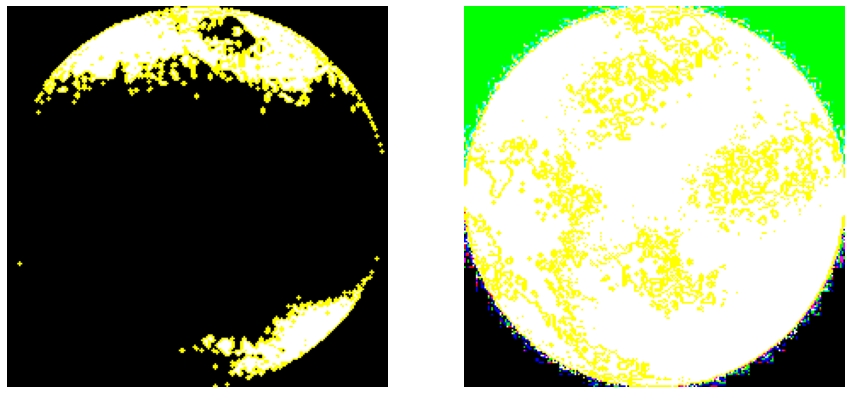

In [ ]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

#Modeling with EfficientNETV2

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'

tf.keras.backend.clear_session()

np.random.seed(0)

model = Sequential()
inp = Input(shape=(224,224,3),name='Input_Layer')
model.add(inp)
model.add(data_augmentation)

eff = tf.keras.applications.efficientnet_v2.EfficientNetV2L(include_top=False, weights='imagenet')
eff.trainable = False
model.add(eff)
model.add(layers.BatchNormalization())
Con = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv1')
model.add(Con)
model.add(layers.BatchNormalization())

flat = Flatten(data_format='channels_last',name='Flatten')
model.add(flat)

FC1 = Dense(units=112,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')
model.add(FC1)
model.add(layers.BatchNormalization())
FC2 = Dense(units=64,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2')
model.add(FC2)

Out = Dense(units=2,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')
model.add(Out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1280)       5120      
 ormalization)                                                   
                                                                 
 Conv1 (Conv2D)              (None, 5, 5, 128)         1474688   
                                                                 
 batch_normalization_1 (Batc  (None, 5, 5, 128)        512       
 hNormalization)                                                 
                                                        

In [ ]:
model.fit(train_left,epochs=50, validation_data=test_left)

Epoch 1/50
160/160 [==============================] - 64s 225ms/step - loss: 0.1499 - Precision: 0.9537 - Recall: 0.9537 - val_loss: 0.0806 - val_Precision: 0.9750 - val_Recall: 0.9750
Epoch 2/50
160/160 [==============================] - 28s 177ms/step - loss: 0.1033 - Precision: 0.9687 - Recall: 0.9687 - val_loss: 0.1400 - val_Precision: 0.9406 - val_Recall: 0.9406
Epoch 3/50
160/160 [==============================] - 28s 177ms/step - loss: 0.0807 - Precision: 0.9758 - Recall: 0.9758 - val_loss: 0.1415 - val_Precision: 0.9547 - val_Recall: 0.9547
Epoch 4/50
160/160 [==============================] - 28s 177ms/step - loss: 0.0779 - Precision: 0.9719 - Recall: 0.9719 - val_loss: 0.1596 - val_Precision: 0.9469 - val_Recall: 0.9469
Epoch 5/50
160/160 [==============================] - 28s 177ms/step - loss: 0.0815 - Precision: 0.9730 - Recall: 0.9730 - val_loss: 0.0835 - val_Precision: 0.9641 - val_Recall: 0.9641
Epoch 6/50
160/160 [==============================] - 28s 177ms/step - loss

In [ ]:
prediction = model.predict(test_left)

In [ ]:
prediction

array([[1.2144112e-08, 1.0000000e+00],
       [8.6872865e-24, 1.0000000e+00],
       [1.8298332e-23, 1.0000000e+00],
       ...,
       [1.8486247e-28, 1.0000000e+00],
       [1.4549663e-34, 1.0000000e+00],
       [1.7216012e-15, 1.0000000e+00]], dtype=float32)

In [ ]:
classes = np.argmax(prediction, axis=-1)
classes

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

f1_score(test_left.classes,classes, average=None)

array([0.05633803, 0.9445823 ])

In [ ]:
confusion_matrix(test_left.classes,classes)

array([[  2,  28],
       [ 39, 571]])

In [ ]:
prediction = model.predict(train_left)

In [ ]:
prediction

array([[1.8293132e-12, 1.0000000e+00],
       [6.7119477e-29, 1.0000000e+00],
       [2.7680214e-27, 1.0000000e+00],
       ...,
       [4.0438674e-15, 1.0000000e+00],
       [2.8269648e-15, 1.0000000e+00],
       [9.3395215e-11, 1.0000000e+00]], dtype=float32)

In [ ]:
classes = np.argmax(prediction, axis=-1)
classes

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

f1_score(train_left.classes,classes, average=None)

array([0.02352941, 0.94877597])

In [ ]:
confusion_matrix(train_left.classes,classes)

array([[   3,  120],
       [ 129, 2306]])

In [ ]:
url = './preprocessed_images/0_left.jpg'

In [ ]:
def read_and_transform_img(url):

    img = keras.preprocessing.image.load_img(
    url, target_size=(224,224))
    img_array = keras.preprocessing.image.img_to_array(img)
    #img_array = tf.expand_dims(img_array, 0)

    return img_array

images = read_and_transform_img(url)

In [ ]:
images.shape

(224, 224, 3)

In [ ]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images.astype('double'), model.predict,  
                                         top_labels=10, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

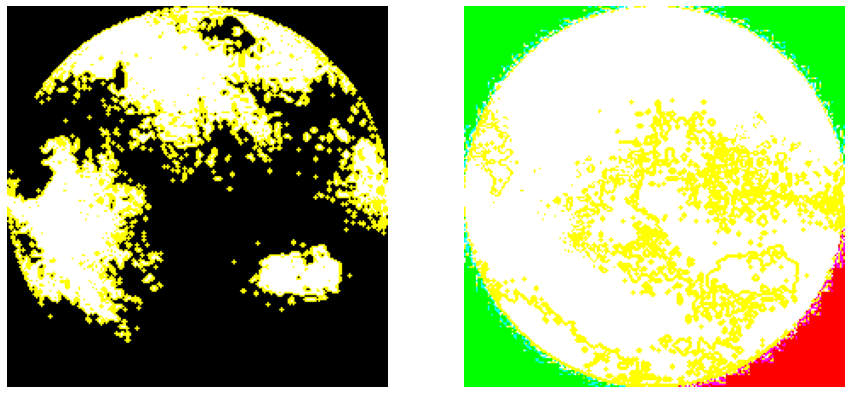

In [ ]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

#Modeling with EfficientNETV2 small

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'

tf.keras.backend.clear_session()

np.random.seed(0)

model = Sequential()
inp = Input(shape=(224,224,3),name='Input_Layer')
model.add(inp)
model.add(data_augmentation)

eff = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights='imagenet')
eff.trainable = False
model.add(eff)
model.add(layers.BatchNormalization())
Con = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv1')
model.add(Con)
model.add(layers.BatchNormalization())

flat = Flatten(data_format='channels_last',name='Flatten')
model.add(flat)

FC1 = Dense(units=112,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')
model.add(FC1)
model.add(layers.BatchNormalization())
FC2 = Dense(units=64,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2')
model.add(FC2)

Out = Dense(units=2,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')
model.add(Out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1280)       5120      
 ormalization)                                                   
                                                                 
 Conv1 (Conv2D)              (None, 5, 5, 128)         1474688   
                                                                 
 batch_normalization_1 (Batc  (None, 5, 5, 128)        512       
 hNormalization)                                                 
                                                        

In [ ]:
model.fit(train_left,epochs=50, validation_data=test_left)

Epoch 1/50
160/160 [==============================] - 31s 141ms/step - loss: 0.1202 - Precision: 0.9556 - Recall: 0.9556 - val_loss: 0.1405 - val_Precision: 0.9312 - val_Recall: 0.9312
Epoch 2/50
160/160 [==============================] - 20s 128ms/step - loss: 0.0882 - Precision: 0.9687 - Recall: 0.9687 - val_loss: 0.1059 - val_Precision: 0.9547 - val_Recall: 0.9547
Epoch 3/50
160/160 [==============================] - 21s 128ms/step - loss: 0.0831 - Precision: 0.9699 - Recall: 0.9699 - val_loss: 0.1157 - val_Precision: 0.9406 - val_Recall: 0.9406
Epoch 4/50
160/160 [==============================] - 20s 128ms/step - loss: 0.0726 - Precision: 0.9750 - Recall: 0.9750 - val_loss: 0.0529 - val_Precision: 0.9891 - val_Recall: 0.9891
Epoch 5/50
160/160 [==============================] - 21s 128ms/step - loss: 0.0736 - Precision: 0.9769 - Recall: 0.9769 - val_loss: 0.2623 - val_Precision: 0.9172 - val_Recall: 0.9172
Epoch 6/50
160/160 [==============================] - 21s 128ms/step - loss

In [ ]:
prediction = model.predict(test_left)

In [ ]:
prediction

array([[2.0029478e-19, 1.0000000e+00],
       [5.8074320e-18, 1.0000000e+00],
       [3.5774531e-14, 1.0000000e+00],
       ...,
       [4.8805525e-30, 1.0000000e+00],
       [3.0393469e-19, 1.0000000e+00],
       [1.5736094e-17, 1.0000000e+00]], dtype=float32)

In [ ]:
classes = np.argmax(prediction, axis=-1)
classes

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

f1_score(test_left.classes,classes, average=None)

array([0.03333333, 0.95245902])

In [ ]:
confusion_matrix(test_left.classes,classes)

array([[  1,  29],
       [ 29, 581]])

In [ ]:
prediction = model.predict(train_left)

In [ ]:
prediction

array([[2.0739759e-11, 1.0000000e+00],
       [1.4991570e-16, 1.0000000e+00],
       [6.3541223e-19, 1.0000000e+00],
       ...,
       [0.0000000e+00, 1.0000000e+00],
       [3.1916498e-37, 1.0000000e+00],
       [4.3275505e-12, 1.0000000e+00]], dtype=float32)

In [ ]:
classes = np.argmax(prediction, axis=-1)
classes

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

f1_score(train_left.classes,classes, average=None)

array([0.01666667, 0.95159967])

In [ ]:
confusion_matrix(train_left.classes,classes)

array([[   2,  121],
       [ 115, 2320]])

In [ ]:
url = './preprocessed_images/0_left.jpg'

In [ ]:
def read_and_transform_img(url):

    img = keras.preprocessing.image.load_img(
    url, target_size=(224,224))
    img_array = keras.preprocessing.image.img_to_array(img)

    return img_array

images = read_and_transform_img(url)

In [ ]:
images.shape

(224, 224, 3)

In [ ]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images.astype('double'), model.predict,  
                                         top_labels=10, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

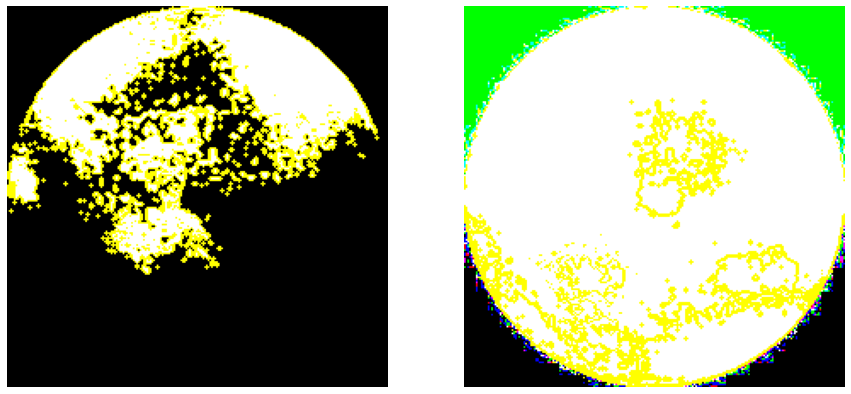

In [ ]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

#Prediction on single image using EfficientNetV2

In [ ]:
idx = []
for i in range(len(train_left.classes)):
         if train_left.classes[i] != classes[i]:
               idx.append(i)

In [ ]:
len(idx), len(train_left.classes)

(236, 2558)

In [ ]:
train = train.reset_index(drop=True)

In [ ]:
fn = []
tr = []
for j in idx:
     filename = train['Left-Fundus'][j]
     fn.append(filename)
     tr.append(train['cataract'][j])

In [ ]:
fn[2], tr[2]

('2128_left.jpg', 'cat')

In [ ]:
url = './preprocessed_images/2128_left.jpg'

In [ ]:
def read_and_transform_img(url):

    img = keras.preprocessing.image.load_img(
    url, target_size=(224,224))
    img_array = keras.preprocessing.image.img_to_array(img)

    return img_array

images = read_and_transform_img(url)

In [ ]:
images.shape

(224, 224, 3)

In [ ]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images.astype('double'), model.predict,  
                                         top_labels=10, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

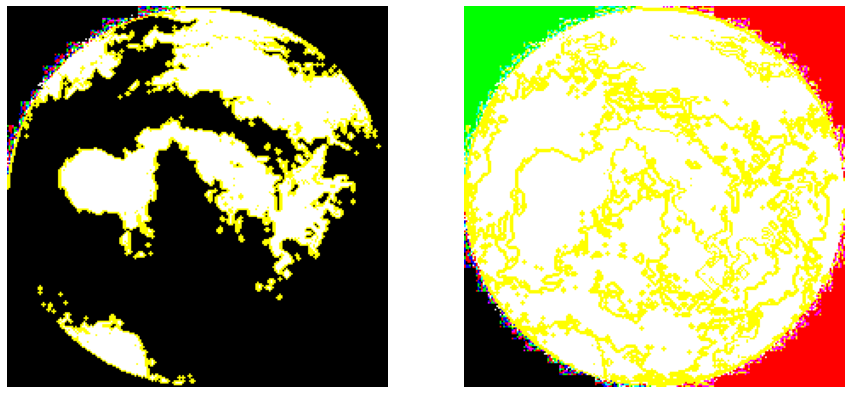

In [ ]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [ ]:
img_array = tf.expand_dims(images, 0)

In [ ]:
pred = model.predict(img_array)
cl = np.max(pred)
cl

0.82528275

In [ ]:
cla = np.argmax(pred, axis=-1)
cla

array([0])

In [ ]:
pred

array([[0.82528275, 0.17471726]], dtype=float32)

In [ ]:
idx[2]

46

In [ ]:
train_left.classes[46], classes[46]

(0, 1)